## Imports

In [1]:
import torch
from lime import lime_image
import numpy as np
from skimage.segmentation import mark_boundaries

In [2]:
%run models/__init__.py

In [3]:
%run utils.py

In [4]:
%run utilsT.py

In [5]:
%run utilsTesting.py

In [6]:
%run -n train.py

In [7]:
device = get_torch_device(gpu=False)
device

device(type='cpu')

## Load model

In [8]:
run_name = "1121_180210_resnet_v3_wd0.5_Cardiomegaly"
# run_name = "0107_132136_resnet_v3_Cardiomegaly"
# run_name = "0115_223657_resnet_v3_os_Cardiomegaly"
# run_name = "1103_132133_Cardiomegaly"

In [9]:
%run models/__init__.py

In [10]:
model, model_name, optimizer, opt_name, loss_name, loss_params, chosen_diseases = load_model(
    BASE_DIR, run_name, force_multiple_gpu=False)
model = model.to(device)

In [11]:
_ = model.train(False)

## Load data

In [12]:
BATCH_SIZE = 4

In [13]:
%%time
dataset, dataloader = prepare_data(DATASET_DIR, "test", ALL_DISEASES, BATCH_SIZE, max_images=None)
n_images, n_diseases = dataset.size()
n_images, n_diseases

CPU times: user 32.6 s, sys: 272 ms, total: 32.9 s
Wall time: 32.9 s


(25596, 14)

In [ ]:
images, labels, names, _, _ = next(iter(dataloader))
images.shape

# LIME

## Prepare functions for LIME

### Transform functions for images

In [14]:
pil_transf, tensor_transf = get_image_transformation_for_lime()

In [15]:
def batch_predict(images):
    batch = torch.stack(tuple(tensor_transf(img) for img in images), dim=0).to(device)
    
    preds, _, _ = model(batch)

    return preds.detach().cpu().numpy()

#### Test `batch_predict`

In [16]:
image_name = "00012288_000.png"
pil_image = load_pil_image(image_name)
preds = batch_predict([pil_transf(pil_image)])
preds

array([[0.10357809]], dtype=float32)

## LIME explainer

In [17]:
def plot_explanation(explanation, num_features=10, hide_rest=False):
    temp, mask = explanation.get_image_and_mask(explanation.top_labels[0],
                                                positive_only=False,
                                                num_features=num_features,
                                                hide_rest=hide_rest)
    plt.imshow(mark_boundaries(temp/255.0, mask))

In [18]:
explainer = lime_image.LimeImageExplainer()

def predict_and_explain(image_name,
                        top_labels=5,
                        num_features=10,
                        hide_color=0,
                        distance_metric='cosine'):
    pil_image = load_pil_image(image_name)
    
    explanation = explainer.explain_instance(np.array(pil_transf(pil_image)),
                                             batch_predict,
                                             top_labels=top_labels,
                                             hide_color=hide_color,
                                             distance_metric=distance_metric,
                                             num_samples=1000)
    
    plot_explanation(explanation, num_features=num_features)
    
    return explanation

In [19]:
def plot_lime_and_activation(image_name, num_features=10, thresh=0.5, show_bboxes=True):
    _, gt, pred, bboxes, activation = gen_image_with_bbox(model, dataset, image_name, chosen_diseases, device)

    plt.figure(figsize=(15, 5))

    plt.subplots_adjust(wspace=0.5)
    plt.subplot(1, 2, 1)
    expl = predict_and_explain(image_name, num_features=num_features)
    
    if show_bboxes:
        plot_bboxes(bboxes)
    
    plt.subplot(1, 2, 2)
    plot_activation(activation, pred, gt, chosen_diseases, disease_name=chosen_diseases[0])
    
    print("Prediction: ", get_labels_as_string(pred >= thresh, chosen_diseases, sep=","))
    print("Ground truth: ", get_labels_as_string(gt, chosen_diseases, sep=","))
    print("R^2 of the linear explanation: ", expl.score)
    
    return expl

## Test some examples

100% |########################################################################|


Prediction:  Normal
Ground truth:  Cardiomegaly
R^2 of the linear explanation:  0.22150096853168177


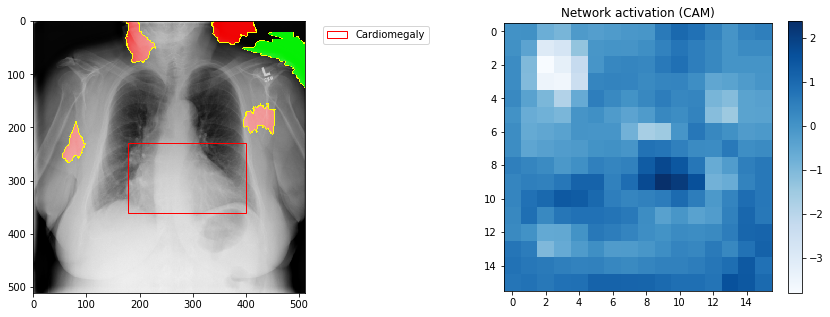

In [20]:
image_name = "00012288_000.png"
expl = plot_lime_and_activation(image_name, num_features=5)

100% |########################################################################|


Prediction:  Normal
Ground truth:  Cardiomegaly
R^2 of the linear explanation:  0.45909816790023006


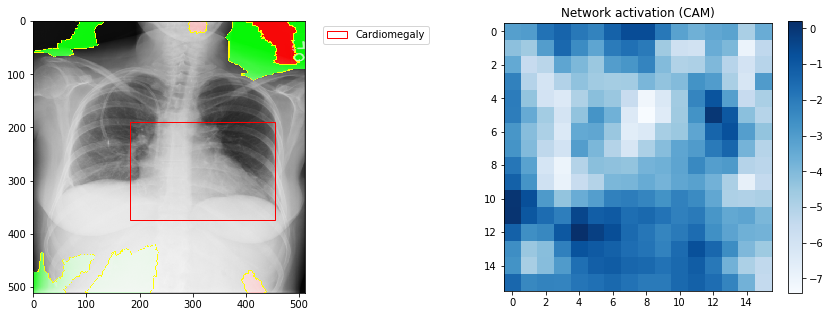

In [31]:
image_name = "00008399_007.png"
expl = plot_lime_and_activation(image_name)

In [70]:
expl.local_pred

array([-0.00830024])

100% |########################################################################|


Prediction:  Normal
Ground truth:  Cardiomegaly
R^2 of the linear explanation:  0.2701279493424147


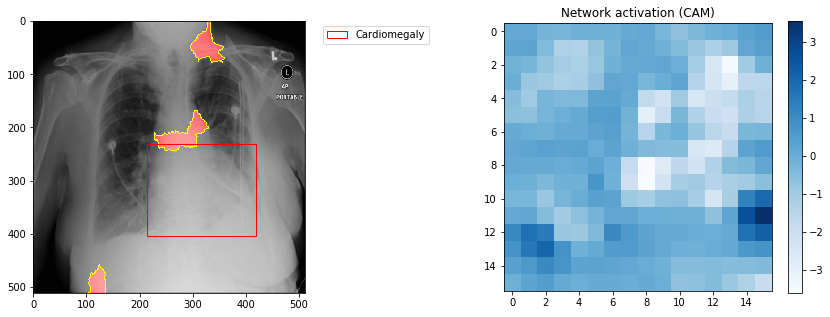

In [21]:
image_name = "00000732_005.png"
expl = plot_lime_and_activation(image_name, num_features=3)

## Test different distance metrics

100% |########################################################################|


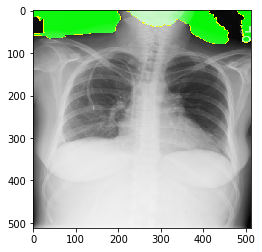

In [45]:
expl = predict_and_explain(image_name, distance_metric="l2")

100% |########################################################################|


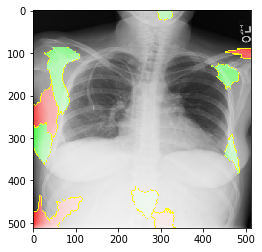

In [50]:
expl = predict_and_explain(image_name, distance_metric="cosine")

# SHAP

In [15]:
import shap

In [16]:
shap.initjs()

In [29]:
from torchvision import transforms
import torch.nn.functional as F

In [27]:
# transf = transforms transforms.Normalize([0.50576189], [1.])
# resize = transforms.Resize(32)

In [17]:
batch_size = 4
height, width = 512, 512

In [35]:
def batch_predict_shap(images):
    bs = int(np.prod(images.shape) / (3*height*width))
    
    batch = torch.Tensor(images.reshape((bs, 3, height, width))).to(device)
     
    preds, _, _ = model(batch)

    return preds.detach().cpu().numpy()

In [36]:
background = np.zeros((4, 3*height*width))

In [37]:
shap_explainer = shap.KernelExplainer(batch_predict_shap, background, link="logit")

In [21]:
batch = next(iter(dataloader))
images = batch[0]

In [22]:
images = images[:1]

In [30]:
images_2 = F.interpolate(images, size=128)
images_2.shape

torch.Size([1, 3, 128, 128])

In [31]:
height, width = 128, 128

In [32]:
images_flatten = np.array(images_2).reshape((1, 3*height*width))
images_flatten.shape

(1, 49152)

In [38]:
shap_values = shap_explainer.shap_values(images_flatten, n_samples=1)
shap_values

MemoryError: Unable to allocate array with shape (100352, 196608) and data type float64